In [1]:
from gurobipy import *
import snap
from graphviz import Digraph
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
IP = []
LP_R = []
X_axis = []
for i in range(10,110,10):
    print("目前跑到這裡=",i)
    X_axis.append(i)
    nodes = i
    edges = i*2.5
    print("nodes",nodes)
    print("edges",edges)
    G1 = snap.GenRndGnm(snap.TUNGraph, int(nodes), int(edges))
    #參數設定
    Budget = 2
    init_S = 0
    #刪除孤單的點
    lonely_node = []
    for NI in G1.Nodes():
        if NI.GetOutDeg()==0:
            lonely_node.append(NI.GetId())
            G1.DelNode(NI.GetId())
    AllnodeID = []
    InfectednodeID = [init_S]
    V = [] #AllnodeID\0(s) #vulnerablenodeID
    vaccinatednodeID = [] #vaccinated的node
    for NI in G1.Nodes():
        AllnodeID.append(NI.GetId())
        if(NI.GetId()!=init_S):
            V.append(NI.GetId())
            
    layer = 0
    for NI in G1.Nodes():
        if(G1.GetShortPath(NI.GetId(),init_S)>layer):
            layer = G1.GetShortPath(NI.GetId(),init_S)

#IP Programming
    B = Budget #budget
    S = init_S #初始感染點
    #Create empty model
    IP_model = Model('IP Vaccination Strategy')

    #add variablies
    #S = model.addVars([(u,t) for u in V for t in range(1,layer+1)],vtype=GRB.BINARY, name="S")
    X = IP_model.addVars([(u,t) for u in V for t in range(1,layer+1) ],vtype=GRB.BINARY, name="X")
    Y = IP_model.addVars([(v) for v in V],vtype=GRB.BINARY, name="Y")
    IP_model.update()
    #add objective function
    # obj = 0
    # for v in V:
    #     obj = obj+Y[v]
    IP_model.setObjective(quicksum(Y[v] for v in V) ,GRB.MAXIMIZE)

    #constraint 1
    IP_model.addConstrs(quicksum(X[u,t] for u in V)<=B for t in range(1,layer+1))
    #constraint 2
    #model.addConstrs(quicksum(X[u,t] for t in range(1,layer+1))<=1 for u in V) 
    #constraint 3
    IP_model.addConstrs(quicksum(X[u,t] for u in V for t in range(1,(G1.GetShortPath(S,v)-G1.GetShortPath(u,v))+1) if t>=0 )>= Y[v]  for v in V)
    IP_model.update()
    IP_model.optimize()
    
    IP.append(IP_model.ObjVal)
    
#LP Programming
    B = Budget #budget
    S = init_S #初始感染點
    #Create empty model
    LP_model = Model('LP Vaccination Strategy')

    #add variablies
    #S = model.addVars([(u,t) for u in V for t in range(1,layer+1)],vtype=GRB.BINARY, name="S")
    X = LP_model.addVars([(u,t) for u in V for t in range(1,layer+1) ],lb=0,ub=1, name="X")
    Y = LP_model.addVars([(v) for v in V],lb=0,ub=1, name="Y")
    LP_model.update()
    #add objective function
    # obj = 0
    # for v in V:
    #     obj = obj+Y[v]
    LP_model.setObjective(quicksum(Y[v] for v in V) ,GRB.MAXIMIZE)

    #constraint 1
    LP_model.addConstrs(quicksum(X[u,t] for u in V)<=B for t in range(1,layer+1))
    #constraint 3
    LP_model.addConstrs(quicksum(X[u,t] for u in V for t in range(1,(G1.GetShortPath(S,v)-G1.GetShortPath(u,v))+1) if t>=0 )>= Y[v]  for v in V)
    LP_model.update()
    LP_model.optimize()
    
    THE_X = [] #取出X[,]
    X_Pro = [] #取出X[,]的機率
#     print("LP Programming")
#     print("保護的個數=",LP_model.ObjVal)
    for var in LP_model.getVars():
        if(var.x>0):
            if(var.varName[0]=="X"):
                THE_X.append(var.varName) 
                X_Pro.append(var.x)
#             print(var.varName,'\t', var.x)

#LP Rounding
    def copy_graph(graph):
        tmpfile = '.copy.bin'

        # Saving to tmp file
        FOut = snap.TFOut(tmpfile)
        graph.Save(FOut)
        FOut.Flush()

        # Loading to new graph
        FIn = snap.TFIn(tmpfile)
        graphtype = type(graph)
        new_graph = graphtype.New()
        new_graph = new_graph.Load(FIn)

        return new_graph

    timer = 10
    count = 0
#     print("LP Rounding")
    for i in range(timer):
        print("round=",i)
        random_strategy_choose = [] #新策略(格式很亂)
        new_strategy = [[]for i in range(layer)]#新策略(格式清理過)

        for i in range(1,layer+1): #以每一個時間抓出來算機率
            XX = []
            XX_ori = []
            XX_Pro = []

            for x in range(len(THE_X)):
                if THE_X[x][-4]==",":
                    if THE_X[x][-3:-1]==str(i):
                        XX.append(THE_X[x])
                        XX_Pro.append(X_Pro[x])
                elif THE_X[x][-2]==str(i):
                    XX.append(THE_X[x])
                    XX_Pro.append(X_Pro[x])
            if(len(XX)==0): #如果在某時沒有注射
                continue
            XX_ori = XX
    #         print("XX_ori",len(XX_ori))
    #         print("XX",XX)
    #         print("XX_Pro",XX_Pro)
            for i in range(B): #每一個時間挑B個
                if(len(XX_ori)<B):
                    random_strategy_choose.append(XX)
                    break
                else:
                    rdc = random.choices(XX, weights=XX_Pro,k=1) #這次的策略
    #                 print("rdc",rdc)
                    del XX_Pro[XX.index(rdc[0])]
                    XX.remove(rdc[0])

                    random_strategy_choose.append(rdc)
    #         print("strategy",random_strategy_choose)
        #清理格式    
        for i in range(len(random_strategy_choose)):
            if(random_strategy_choose[i][0][-4]==","): #注射時間是十位數
                new_strategy[int(random_strategy_choose[i][0][-3:-1])-1].append(random_strategy_choose[i][0][2:-4])
            else: #注射時間是個位數
                new_strategy[int(random_strategy_choose[i][0][-2])-1].append(random_strategy_choose[i][0][2:-3])

    #     new_strategy = list(map(int, new_strategy)) #str-->int
#         print("選擇的策略=",new_strategy)
        ########################################################################開始注射策略
        G_temp = copy_graph(G1)
        S = init_S #初始感染點
        temp_vaccinated = []
        temp_infected = [S]
        temp_vulnerable = V.copy()    
        for i in range(len(new_strategy)): #開始依序注射
            if(len(new_strategy[i])==0):#如果這個時間點沒有注射
                for n in range(len(a)):#病毒開始擴散
                    if(G_temp.GetShortPath(S,a[n])==i+1):
                        temp_infected.append(a[n])
                        temp_vulnerable.remove(a[n])
                continue
            TT_saved = []
            ttemp_saved = []
            for j in range(len(new_strategy[i])):
    #             temp_saved = []
                b = temp_vulnerable.copy()
                if(int(new_strategy[i][j]) not in temp_vulnerable): #如果要注射的點已經被保護了(從圖中刪除)
    #                 for n in range(len(b)):
    #                      if(G_temp.GetShortPath(S,b[n])==i+1):#病毒開始擴散
    #                         temp_infected.append(b[n])
    #                         temp_vulnerable.remove(b[n])
                    continue


                for k in range(len(temp_vulnerable)):#每一個點計算是否有被注射的點保護

                    r  = i+1
                    if(r<=(G_temp.GetShortPath(S,temp_vulnerable[k])-G_temp.GetShortPath(int(new_strategy[i][j]),temp_vulnerable[k]))):
                        ttemp_saved.append(temp_vulnerable[k])

            temp_saved = list(dict.fromkeys(ttemp_saved))
            for m in range(len(temp_saved)): #調整位置
                temp_vaccinated.append(temp_saved[m])
                temp_vulnerable.remove(temp_saved[m])
                G_temp.DelNode(temp_saved[m])

            a = temp_vulnerable.copy()
            for n in range(len(a)):#病毒開始擴散
                if(G_temp.GetShortPath(S,a[n])==i+1):
                    temp_infected.append(a[n])
                    temp_vulnerable.remove(a[n])


#         print("保護個數=",len(temp_vaccinated))
        count = count+int(len(temp_vaccinated))
    #     print("被保護的點=",temp_vaccinated)
#     print("平均被保護個數=",count/timer)
    LP_R.append(count/timer)


目前跑到這裡= 10
nodes 10
edges 25.0
Academic license - for non-commercial use only - expires 2021-07-24
Using license file C:\Users\user\gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 27 columns and 66 nonzeros
Model fingerprint: 0x15a939d9
Variable types: 0 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 4 rows and 12 columns
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 37 nonzeros
Found heuristic solution: objective 7.0000000
Variable types: 0 continuous, 15 integer (14 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 53 rows, 245 columns and 1008 nonzeros
Model fingerprint: 0x8cfab289
Variable types: 0 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 9 rows and 112 columns
Presolve time: 0.00s
Presolved: 44 rows, 133 columns, 784 nonzeros
Found heuristic solution: objective 24.0000000
Variable types: 0 continuous, 133 integer (133 binary)

Root relaxation: objective 3.800000e+01, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      38.0000000   38.00000  0.00%     -    0s

Explored 

Presolve time: 0.01s
Presolved: 80 rows, 331 columns, 4578 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7000000e+01   3.000000e+01   0.000000e+00      0s
       5    7.7000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds
Optimal objective  7.700000000e+01
round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
目前跑到這裡= 90
nodes 90
edges 225.0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 93 rows, 445 columns and 2528 nonzeros
Model fingerprint: 0x4dc69343
Variable types: 0 continuous, 445 integer (445 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8 rows and 168 columns
Presolve time: 0.

In [3]:
IP

[7.0, 14.0, 25.0, 22.0, 38.0, 36.0, 53.0, 77.0, 64.0, 88.0]

In [4]:
LP_R

[7.0, 12.2, 25.0, 22.0, 38.0, 36.0, 48.9, 77.0, 64.0, 88.0]

In [5]:
X_axis

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

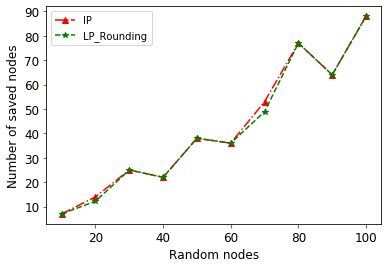

In [6]:
Data_1, = plt.plot(X_axis,IP,'r-.^',label='IP') #畫線
Data_2, = plt.plot(X_axis, LP_R, 'g--*',label='LP_Rounding') #畫線

plt.tick_params(axis='both', labelsize=12, color='green')
plt.legend(handles=[Data_1, Data_2])
plt.xlabel("Random nodes", fontsize=12) #x軸標題
plt.ylabel("Number of saved nodes", fontsize=12) #y軸標題
plt.show() #顯示繪製的圖形